# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier

# Obtain Data

In [2]:
df = pd.read_csv('Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Scrub Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Drop columns not useful for modeling

In [4]:
df.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Parch', 'SibSp'], inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,S


Create dummy columns for Pclass and categorical variables

In [5]:
df = pd.get_dummies(df, columns=['Pclass', 'Sex'], drop_first=False)
df.drop(columns=['Pclass_2', 'Sex_female'], inplace=True)
df.head()

,Survived,Name,Age,Fare,Embarked,Pclass_1,Pclass_3,Sex_male
0,0,"Braund, Mr. Owen Harris",22.0,7.2500,S,0,1,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,C,1,0,0
2,1,"Heikkinen, Miss. Laina",26.0,7.9250,S,0,1,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,53.1000,S,1,0,0
4,0,"Allen, Mr. William Henry",35.0,8.0500,S,0,1,1


Create dummy columns for Embarked variable, while mantaining Embarked np.nan values in the dummy columns

In [6]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=False, dummy_na=True)
df.drop(columns=['Embarked_Q'], inplace=True)

def embarked_na(row):
    if row['Embarked_nan'] == 1:
        row['Embarked_S'] = np.nan
        row['Embarked_C'] = np.nan
        return row
    else:
        return row

df = df.apply(embarked_na, axis=1)
df.drop(columns='Embarked_nan', inplace=True)
df.head()

,Survived,Name,Age,Fare,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S
0,0,"Braund, Mr. Owen Harris",22.0,7.2500,0,1,1,0.0,1.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,71.2833,1,0,0,1.0,0.0
2,1,"Heikkinen, Miss. Laina",26.0,7.9250,0,1,0,0.0,1.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,53.1000,1,0,0,0.0,1.0
4,0,"Allen, Mr. William Henry",35.0,8.0500,0,1,1,0.0,1.0


Create Title feature from Name

In [7]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df.drop(columns=['Name'], inplace=True)
df.head()

,Survived,Age,Fare,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title
0,0,22.0,7.2500,0,1,1,0.0,1.0,Mr
1,1,38.0,71.2833,1,0,0,1.0,0.0,Mrs
2,1,26.0,7.9250,0,1,0,0.0,1.0,Miss
3,1,35.0,53.1000,1,0,0,0.0,1.0,Mrs
4,0,35.0,8.0500,0,1,1,0.0,1.0,Mr


Merge all special titles into a single class

In [8]:
def special_title(row):
    if row['Title'] in ['Mr', 'Miss', 'Mrs', 'Master']:
        return row['Title']
    elif row['Title'] in ['Mlle', 'Ms']:
        return 'Miss'
    elif row['Sex_male'] == 0:
        return 'Mrs'
    else: 
        return 'Special'
df['Title'] = df.apply(special_title, axis=1)
df.head()

,Survived,Age,Fare,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title
0,0,22.0,7.2500,0,1,1,0.0,1.0,Mr
1,1,38.0,71.2833,1,0,0,1.0,0.0,Mrs
2,1,26.0,7.9250,0,1,0,0.0,1.0,Miss
3,1,35.0,53.1000,1,0,0,0.0,1.0,Mrs
4,0,35.0,8.0500,0,1,1,0.0,1.0,Mr


Create dummy variables for Title feature

In [9]:
df = pd.get_dummies(df, columns=['Title'], drop_first=False)
df.drop(columns=['Title_Special'], inplace=True)
df.head()

,Survived,Age,Fare,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,22.0,7.2500,0,1,1,0.0,1.0,0,0,1,0
1,1,38.0,71.2833,1,0,0,1.0,0.0,0,0,0,1
2,1,26.0,7.9250,0,1,0,0.0,1.0,0,1,0,0
3,1,35.0,53.1000,1,0,0,0.0,1.0,0,0,0,1
4,0,35.0,8.0500,0,1,1,0.0,1.0,0,0,1,0


Impute missing age values with knn imputer

In [10]:
impute_x = df.drop(columns=['Survived'])
impute_y = df['Survived']

impute_xtrain, impute_xtest, impute_ytrain, impute_ytest = train_test_split(impute_x, impute_y, 
                                                                            test_size=0.25, random_state=121)

impute_ss = StandardScaler()
impute_ss.fit(impute_xtrain)
impute_xtrain = pd.DataFrame(impute_ss.transform(impute_xtrain), columns=impute_xtrain.columns, 
                             index=impute_xtrain.index)
impute_x = pd.DataFrame(impute_ss.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

imputer = KNNImputer()
imputer.fit(impute_xtrain)
impute_x = pd.DataFrame(imputer.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

impute_x = pd.DataFrame(impute_ss.inverse_transform(impute_x), columns=impute_x.columns, index=impute_x.index)
df = pd.concat([impute_x, impute_y], axis=1)
df = df.round(4)
df.head()

,Age,Fare,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived
0,22.0,7.2500,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,38.0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2,26.0,7.9250,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,35.0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,35.0,8.0500,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0


Drop Sex_male feature

In [11]:
df.drop(columns=['Sex_male'], inplace=True)
df.head()

,Age,Fare,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived
0,22.0,7.2500,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2,26.0,7.9250,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,35.0,8.0500,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0


Merge Mrs and Miss titles

In [12]:
df['Title_Ms'] = df['Title_Miss'] + df['Title_Mrs']
df.drop(columns=['Title_Miss', 'Title_Mrs'], inplace=True)
df.head()

,Age,Fare,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Title_Master,Title_Mr,Survived,Title_Ms
0,22.0,7.2500,0.0,1.0,0.0,1.0,0.0,1.0,0,0.0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,1,1.0
2,26.0,7.9250,0.0,1.0,0.0,1.0,0.0,0.0,1,1.0
3,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,1,1.0
4,35.0,8.0500,0.0,1.0,0.0,1.0,0.0,1.0,0,0.0


Merge Master and Mr titles

In [13]:
df['Title_Mr'] = df['Title_Mr'] + df['Title_Master']
df.drop(columns=['Title_Master'], inplace=True)
df.head()

,Age,Fare,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Title_Mr,Survived,Title_Ms
0,22.0,7.2500,0.0,1.0,0.0,1.0,1.0,0,0.0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,1,1.0
2,26.0,7.9250,0.0,1.0,0.0,1.0,0.0,1,1.0
3,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,1,1.0
4,35.0,8.0500,0.0,1.0,0.0,1.0,1.0,0,0.0


Confirm data now scrubbed with df.info()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Fare        891 non-null    float64
 2   Pclass_1    891 non-null    float64
 3   Pclass_3    891 non-null    float64
 4   Embarked_C  891 non-null    float64
 5   Embarked_S  891 non-null    float64
 6   Title_Mr    891 non-null    float64
 7   Survived    891 non-null    int64  
 8   Title_Ms    891 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 62.8 KB


# Explore Data

Find train set outliers with isolation forest

In [15]:
isf_x = df.drop(columns='Survived')
isf_y = df['Survived']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y, test_size=0.25, random_state=121)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.02)
isf_xtrain['Outlier'] = isf.fit_predict(isf_xtrain)
isf_xtrain[isf_xtrain['Outlier']==-1].round(1)

,Age,Fare,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Title_Mr,Title_Ms,Outlier
626,1.9,-0.4,-0.5,-1.1,-0.5,-1.6,-1.3,-0.7,-1
245,1.0,1.5,1.8,-1.1,-0.5,-1.6,-1.3,-0.7,-1
827,-2.1,0.2,-0.5,-1.1,2.1,-1.6,0.8,-0.7,-1
700,-0.9,4.9,1.8,-1.1,2.1,-1.6,-1.3,1.4,-1
258,0.3,11.8,1.8,-1.1,2.1,-1.6,-1.3,1.4,-1
305,-2.1,3.0,1.8,-1.1,-0.5,0.6,0.8,-0.7,-1
311,-0.9,5.7,1.8,-1.1,2.1,-1.6,-1.3,1.4,-1
689,-1.1,4.5,1.8,-1.1,-0.5,0.6,-1.3,1.4,-1
550,-0.9,2.0,1.8,-1.1,2.1,-1.6,0.8,-0.7,-1
557,0.7,4.9,1.8,-1.1,2.1,-1.6,0.8,-0.7,-1


Find test set outliers with Isolation Forest

In [16]:
isf_xtest = pd.DataFrame(isf_ss.transform(isf_xtest), columns=isf_xtest.columns, index=isf_xtest.index)
isf_xtest['Outlier'] = isf.predict(isf_xtest)
isf_xtest[isf_xtest['Outlier']==-1].round(1)

,Age,Fare,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Title_Mr,Title_Ms,Outlier
43,-1.9,0.3,-0.5,-1.1,2.1,-1.6,-1.3,1.4,-1
118,-0.4,5.3,1.8,-1.1,2.1,-1.6,0.8,-0.7,-1
737,0.3,11.8,1.8,-1.1,2.1,-1.6,0.8,-0.7,-1
679,0.4,11.8,1.8,-1.1,2.1,-1.6,0.8,-0.7,-1
742,-0.7,5.7,1.8,-1.1,2.1,-1.6,-1.3,1.4,-1
438,2.4,5.7,1.8,-1.1,-0.5,0.6,0.8,-0.7,-1
9,-1.1,0.0,-0.5,-1.1,2.1,-1.6,-1.3,1.4,-1
27,-0.8,5.7,1.8,-1.1,-0.5,0.6,0.8,-0.7,-1


Replace all Age and Fare values > 4 standard deviations from the mean with the 4 standard deviation value

In [17]:
replace_x = df.drop(columns='Survived')
replace_y = df['Survived']

replace_xtrain, replace_xtest, replace_ytrain, replace_ytest = train_test_split(replace_x, replace_y, 
                                                                            test_size=0.25, random_state=121)

replace_ss = StandardScaler()
replace_ss.fit(replace_xtrain)
replace_xtrain = pd.DataFrame(replace_ss.transform(replace_xtrain), columns=replace_xtrain.columns, 
                             index=replace_xtrain.index)
replace_x = pd.DataFrame(replace_ss.transform(replace_x), columns=replace_x.columns, 
                             index=replace_x.index)

def replace_val(row):
    if row > 4:
        return 4
    if row < -4:
        return -4
    else:
        return row

replace_x['Age'] = replace_x['Age'].apply(replace_val)
replace_x['Fare'] = replace_x['Fare'].apply(replace_val)
replace_x = pd.DataFrame(replace_ss.inverse_transform(replace_x), columns=replace_x.columns, index=replace_x.index)
df = pd.concat([replace_x, replace_y], axis=1)
df = df.round(4)
df.head()

,Age,Fare,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Title_Mr,Title_Ms,Survived
0,22.0,7.2500,0.0,1.0,0.0,1.0,1.0,0.0,0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,1.0,1
2,26.0,7.9250,0.0,1.0,0.0,1.0,0.0,1.0,1
3,35.0,53.1000,1.0,0.0,0.0,1.0,0.0,1.0,1
4,35.0,8.0500,0.0,1.0,0.0,1.0,1.0,0.0,0


Calculate descriptive statistics for each feature

In [18]:
df.describe().iloc[:, 0:10]

,Age,Fare,Pclass_1,Pclass_3,Embarked_C,Embarked_S,Title_Mr,Title_Ms,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.994655,30.254988,0.242424,0.551066,0.189899,0.723681,0.625140,0.352413,0.383838
std,14.037534,38.039924,0.428790,0.497665,0.391868,0.446925,0.484359,0.477990,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.900000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.500000,14.454200,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,39.000000,31.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,80.000000,192.470800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot class distribution for Survived dependent variable

[Text(0, 0, '0 (Non-Survivor)'), Text(1, 0, '1 (Survivor)')]

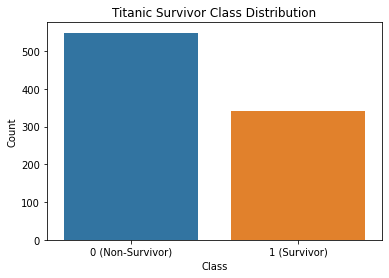

In [19]:
fig, ax = plt.subplots()
sns.countplot(x='Survived', data=df, ax=ax)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Titanic Survivor Class Distribution')
ax.set_xticklabels(['0 (Non-Survivor)', '1 (Survivor)'])

Plot distribution for each feature in Titanic dataset

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

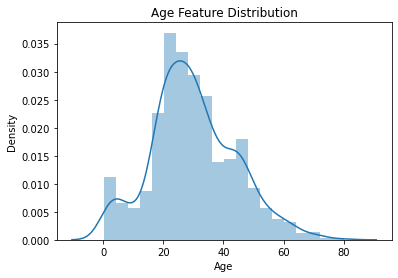

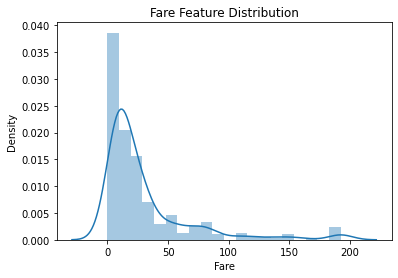

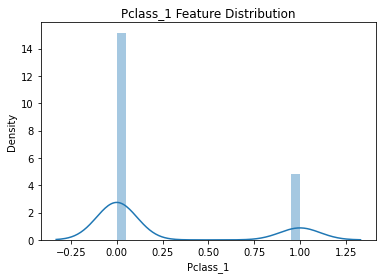

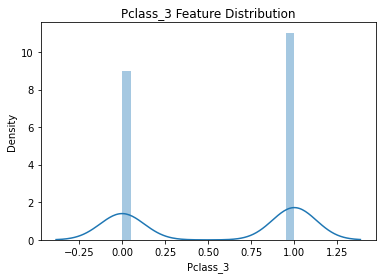

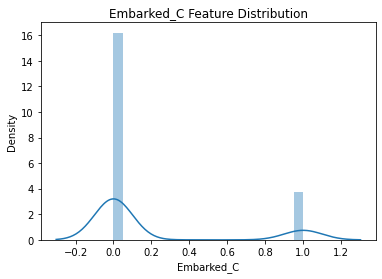

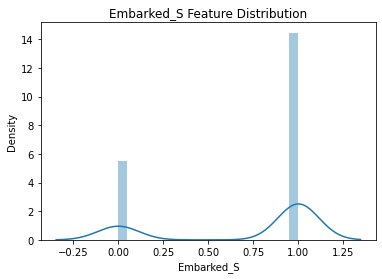

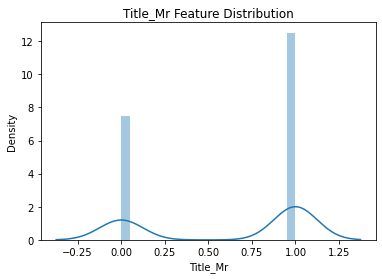

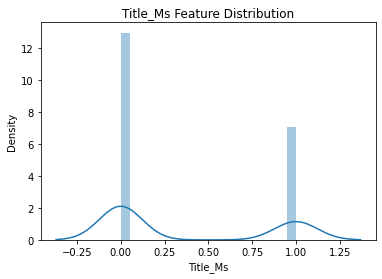

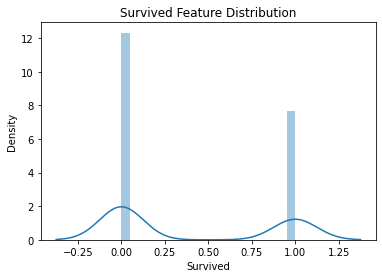

In [20]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=20)
    ax.set_title(f'{feat} Feature Distribution')

Calculate VIF to confirm that there are no correlated features

In [21]:
vif_x = df.drop(columns=['Survived'])
vif_y = df['Survived']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.25, random_state=121)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,76.2
1,Title_Ms,11.4
2,Title_Mr,11.4
3,Embarked_C,2.9
4,Embarked_S,2.8
5,Pclass_1,2.8
6,Fare,2.1
7,Pclass_3,1.9
8,Age,1.4


# Model Data

Create x and y variables

In [34]:
x = df.drop(columns=['Survived', 'Fare'])
y = df['Survived']

Perform train test split

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=121)

Standard scale data

In [36]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)

Build and evaluate dummy classifier

In [37]:
dc = DummyClassifier(strategy='stratified')
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier: 
Train f1 Score:  0.38996138996138996
Train Accuracy Score: 0.5269461077844312
Test f1 Score:  0.3333333333333333
Test Accuracy Score: 0.515695067264574


Gridsearch Logistic Regression Model

In [44]:
lr_gs_dict = {'C': [x/10000 for x in range(60, 81)]}
lr_gs_model = LogisticRegression(random_state=204)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_estimator_)
print(lr_gs.best_score_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
LogisticRegression(C=0.0069, random_state=204)
0.8053866008304343


Build and evaluate top performing gridsearch logistic regression model

In [45]:
lr = LogisticRegression(C=.0069, random_state=204)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression: 
Train f1 Score:  0.7261410788381741
Train Accuracy Score: 0.8023952095808383
Test f1 Score:  0.6826347305389221
Test Accuracy Score: 0.7623318385650224


Gridsearch SVC model

In [55]:
svc_gs_dict = {'C': [x/100 for x in range(100, 151)],
               'gamma': [x/100 for x in range(900, 1001)]}
svc_gs_model = SVC(random_state=491)
svc_gs = GridSearchCV(svc_gs_model, svc_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
svc_gs.fit(x_train, y_train)

print(svc_gs.best_estimator_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 5151 candidates, totalling 25755 fits
SVC(C=1.12, gamma=9.49, random_state=491)
0.8263494557288744


Fit and evaluate top performing SVC model

In [56]:
svc = SVC(C=1.12, gamma=9.49, random_state=491, probability=True)
svc.fit(x_train, y_train)
y_train_pred_svc = svc.predict(x_train)
y_test_pred_svc = svc.predict(x_test)
print('SVC: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_svc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_svc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_svc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_svc))

SVC: 
Train f1 Score:  0.8093220338983051
Train Accuracy Score: 0.8652694610778443
Test f1 Score:  0.6787878787878788
Test Accuracy Score: 0.7623318385650224


Gridsearch adaboost model

In [57]:
ab_gs_dict = {'learning_rate': [x/10 for x in range(0, 101)],
             'n_estimators': [x*10 for x in range(10, 31)]}
ab_gs_model = AdaBoostClassifier(random_state=19)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)

print(ab_gs.best_estimator_)
print(ab_gs.best_score_)

Fitting 5 folds for each of 2121 candidates, totalling 10605 fits
AdaBoostClassifier(learning_rate=1.1, n_estimators=140, random_state=19)
0.8128492873975984


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.20208731 0.20208731 0.20208731]
  warnings.warn(


Fit and evaluate top performing adaboost model

In [126]:
ab = AdaBoostClassifier(learning_rate=.012, n_estimators=300, random_state=19)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_ab))

Adaboost: 
Train f1 Score:  0.7204968944099378
Train Accuracy Score: 0.7979041916167665
Test f1 Score:  0.6820809248554913
Test Accuracy Score: 0.7533632286995515


Gridsearch random forest model

In [135]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [.1, .2, .3],
              'max_leaf_nodes': [2, 3, 4, 5, 6],
              'max_samples': [.05, .055, .06, .065, .07]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
RandomForestClassifier(criterion='entropy', max_features=0.1, max_leaf_nodes=4,
                       max_samples=0.06, n_jobs=-1, random_state=712)
0.8143867130512851


In [143]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [.1, .2, .3],
              'max_samples': [.065, .0675, .07, .0725, .075],
              'min_impurity_decrease': [.001, .002, .003, .004, .005, .006, .007]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
RandomForestClassifier(max_features=0.1, max_samples=0.07,
                       min_impurity_decrease=0.004, n_jobs=-1,
                       random_state=712)
0.8158792503647179


Fit and evaluate top performing random forest model

In [134]:
rf = RandomForestClassifier(criterion='entropy', max_features=0.1, max_leaf_nodes=4, max_samples=0.06, n_jobs=-1,
                       random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.7099767981438514
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.6979865771812079
Test Accuracy Score: 0.7982062780269058


In [144]:
rf = RandomForestClassifier(criterion='entropy', max_features=0.1, max_samples=0.07,
                       min_impurity_decrease=0.004, n_jobs=-1, random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.7099767981438514
Train Accuracy Score: 0.812874251497006
Test f1 Score:  0.6979865771812079
Test Accuracy Score: 0.7982062780269058


Fit and evaluate voting classifier

In [155]:
vc = VotingClassifier([('svc', svc), ('rf', rf)], voting='soft', weights=[1, 0])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Voting Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_vc))

Voting Classifier: 
Train f1 Score:  0.7105882352941176
Train Accuracy Score: 0.8158682634730539
Test f1 Score:  0.7027027027027027
Test Accuracy Score: 0.8026905829596412


<ipython-input-44-e231bc2e62a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_df['Fare'] = joint_df['Fare'].round(-1)


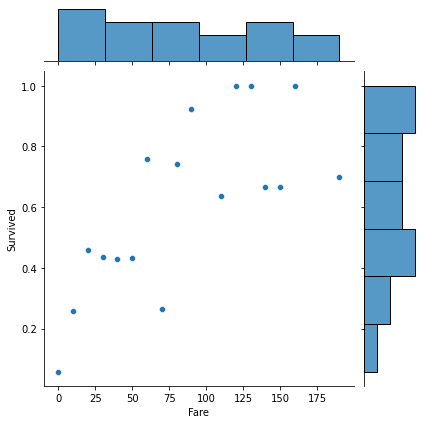

In [44]:
joint_df = df[['Fare', 'Survived']]
joint_df['Fare'] = joint_df['Fare'].round(-1)
joint_df = joint_df.groupby('Fare').mean()[['Survived']].reset_index()
sns.jointplot(x='Fare', y='Survived', data=joint_df)

In [31]:
df.columns

Index(['Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_1.0',
       'SibSp_2.0', 'SibSp_3.0', 'SibSp_4.0', 'Parch_1.0', 'Parch_2.0',
       'Parch_3.0', 'Survived'],
      dtype='object')

In [33]:
df.groupby('Embarked_C').mean()['Survived']

Embarked_C
0.0    0.342580
0.4    1.000000
1.0    0.553571
Name: Survived, dtype: float64

In [34]:
df.groupby('Embarked_Q').mean()['Survived']

Embarked_Q
0.0    0.383292
1.0    0.389610
Name: Survived, dtype: float64

In [35]:
df.groupby('Embarked_S').mean()['Survived']

Embarked_S
0.0    0.502041
0.6    1.000000
1.0    0.336957
Name: Survived, dtype: float64

In [235]:
pd.DataFrame(lr.coef_, columns=x.columns).T.reset_index().sort_values(by=0)

,index,0
4,Sex_male,-0.863842
3,Pclass_3,-0.315829
0,Age,-0.258082
11,SibSp_5.0,-0.221416
9,SibSp_3.0,-0.116436
10,SibSp_4.0,-0.115687
6,Embarked_S,-0.053866
14,Parch_3.0,-0.034785
8,SibSp_2.0,-0.012473
13,Parch_2.0,0.044139


In [197]:
df.corr()['Fare']

Age           0.100958
Fare          1.000000
Pclass_1      0.682347
Pclass_3     -0.483153
Sex_male     -0.225493
Embarked_C    0.276246
Embarked_S   -0.155633
SibSp_1.0     0.194928
SibSp_2.0     0.078200
SibSp_3.0     0.090448
SibSp_4.0     0.006045
SibSp_5.0     0.091760
Parch_1.0     0.129073
Parch_2.0     0.243309
Parch_3.0     0.035550
Survived      0.288140
Name: Fare, dtype: float64

In [240]:
df.groupby('Pclass').mean()['Survived']

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [246]:
df[df['Sex']=='male'].groupby('Pclass').mean()['Survived']

Pclass
1    0.368852
2    0.157407
3    0.135447
Name: Survived, dtype: float64

In [247]:
df[df['Sex']=='female'].groupby('Pclass').mean()['Survived']

Pclass
1    0.968085
2    0.921053
3    0.500000
Name: Survived, dtype: float64

In [253]:
df[df['Pclass']==1].groupby('Sex').count()['Survived']

Sex
female     94
male      122
Name: Survived, dtype: int64

In [254]:
df[df['Pclass']==2].groupby('Sex').count()['Survived']

Sex
female     76
male      108
Name: Survived, dtype: int64

In [255]:
df[df['Pclass']==3].groupby('Sex').count()['Survived']

Sex
female    144
male      347
Name: Survived, dtype: int64

In [267]:
df[(df['Sex']=='female')&(df['Pclass']==3)].groupby('Parch').mean()['Survived']

Parch
0    0.588235
1    0.480000
2    0.320000
3    0.500000
4    0.000000
5    0.250000
6    0.000000
Name: Survived, dtype: float64

In [266]:
df[(df['Sex']=='male')&(df['Pclass']==1)].groupby('Parch').mean()['Survived']

Parch
0    0.363636
1    0.285714
2    0.625000
4    0.000000
Name: Survived, dtype: float64

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [335]:
test_df = pd.read_csv('Data/train.csv')
test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [338]:
test_df['Cabin'] = test_df['Cabin'].replace({np.nan: ' '})
test_df['Floor'] = test_df['Cabin'].apply(lambda x:x[0])
test_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Floor
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,,Q,
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,,S,
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,,S,
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,,C,


In [339]:
test_df['Floor'].value_counts()

     687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Floor, dtype: int64

In [343]:
test_df.groupby('Floor').mean()['Survived']

Floor
     0.299854
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Name: Survived, dtype: float64

In [345]:
test_df[['Ticket','Pclass']].head(50)

,Ticket,Pclass
0,A/5 21171,3
1,PC 17599,1
2,STON/O2. 3101282,3
3,113803,1
4,373450,3
5,330877,3
6,17463,1
7,349909,3
8,347742,3
9,237736,2


In [349]:
test_df[test_df['Sex']=='female'][['Name']]

,Name
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
9,"Nasser, Mrs. Nicholas (Adele Achem)"
...,...
880,"Shelley, Mrs. William (Imanita Parrish Hall)"
882,"Dahlberg, Miss. Gerda Ulrika"
885,"Rice, Mrs. William (Margaret Norton)"
887,"Graham, Miss. Margaret Edith"


In [352]:
test_df[test_df['Sex']=='female'][['Name']].head(50)

,Name
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
9,"Nasser, Mrs. Nicholas (Adele Achem)"
10,"Sandstrom, Miss. Marguerite Rut"
11,"Bonnell, Miss. Elizabeth"
14,"Vestrom, Miss. Hulda Amanda Adolfina"
15,"Hewlett, Mrs. (Mary D Kingcome)"
18,"Vander Planke, Mrs. Julius (Emelia Maria Vande..."


In [240]:
df[(df['Title_Miss']==0)&(df['Title_Mr']==0)&(df['Title_Mrs']==0)&(df['Title_Special']==0)].groupby('Pclass_3').mean()['Survived']

Pclass_3
0.0    1.000000
1.0    0.392857
Name: Survived, dtype: float64

In [249]:
df[(df['Age']>40)&(df['Pclass_1']==1)&(df['Sex_male']==1)].groupby('Title_Special').mean()['Survived']

Title_Special
0.0    0.245902
1.0    0.444444
Name: Survived, dtype: float64

In [245]:
df.columns

Index(['Age', 'Fare', 'Pclass_1', 'Pclass_3', 'Sex_male', 'Embarked_C',
       'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Special',
       'Survived'],
      dtype='object')